In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import chisquare
import pickle
from bs4 import BeautifulSoup
from collections import defaultdict
import requests
from statsmodels.stats.multitest import fdrcorrection_twostage
%matplotlib inline


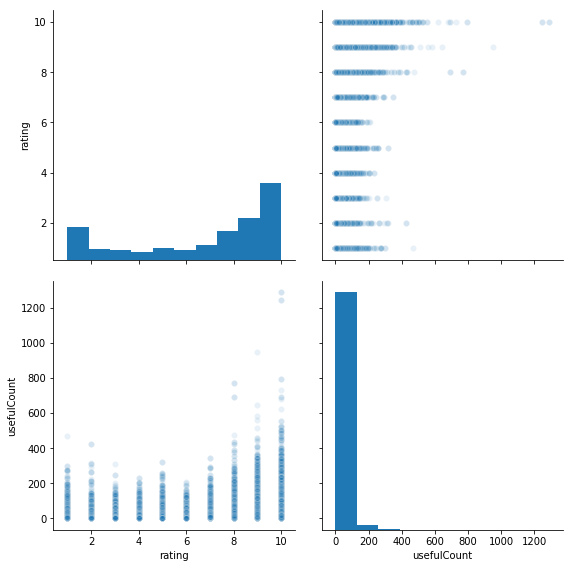

In [239]:
df = pd.read_csv('drugsCom_raw/drugsComTrain_raw.tsv',sep='\t',index_col=0)
sns.pairplot(df, plot_kws={'alpha':0.1},size=4)

In [240]:
df.shape

(161297, 6)

In [241]:
df['date'] = pd.to_datetime(df['date'])

# 1. EDA

## Total number of comments posted each day

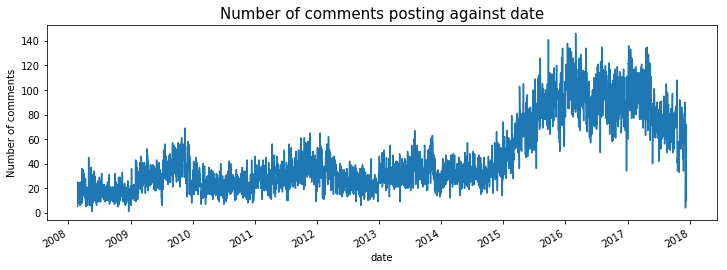

In [242]:
df.groupby('date').size().plot(figsize=(12,4))
plt.ylabel('Number of comments')
plt.title("Number of comments posting against date",fontsize=15)
plt.savefig("Plot/num_comments_date.png")

In [243]:
tem_y = df.groupby('date').size().values
tem_x = df.groupby('date').size().index

In [292]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.graph_objs import *

tools.set_credentials_file(username='superjohnlove', api_key='5b9U2JtJb7zCmDlw8zsz')

trace0 = Scatter(
    x=tem_x,
    y=tem_y)
    
data = Data([trace0])
py.iplot(data)

## Total number of comments posted each month

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



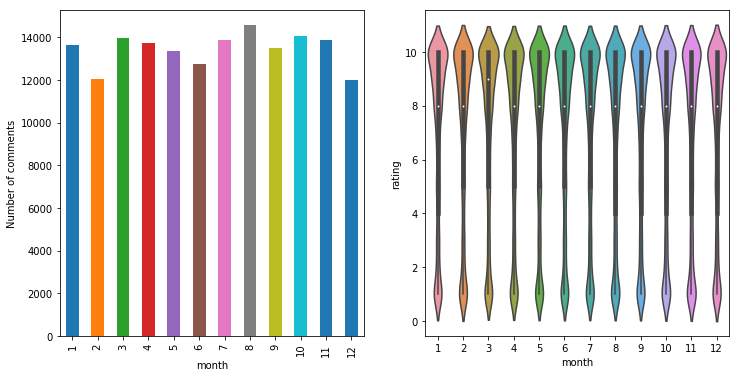

In [245]:
df['month'] = df['date'].apply(lambda x: x.month)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
df.groupby('month').size().plot(kind='bar')
plt.ylabel('Number of comments')

plt.subplot(1, 2, 2)
sns.violinplot(data=df,x='month',y='rating')

## Total number of comments for each condition

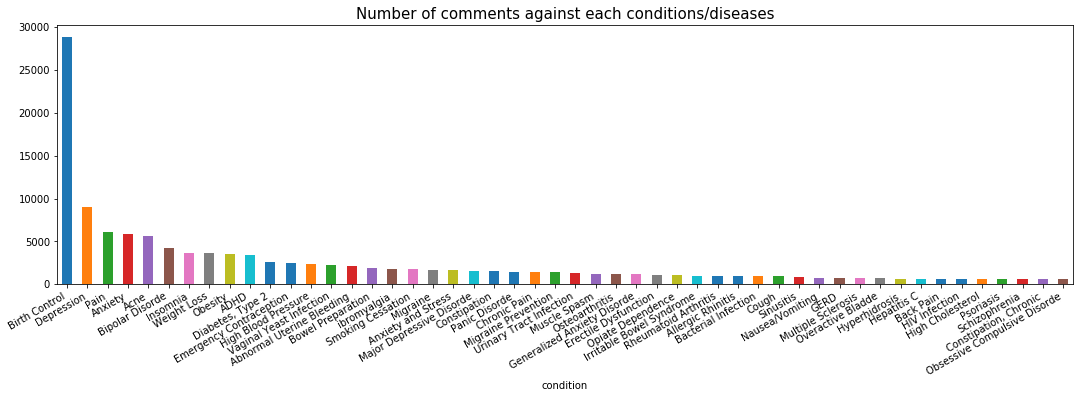

In [246]:
df_con_mon = pd.DataFrame(df.groupby(['condition','month']).size()).reset_index()

df_con_mon_pivot = df_con_mon.pivot_table(index='condition',columns='month',values=0)

fig = plt.figure(figsize=(15,5))
df_con_mon_pivot.sum(1).sort_values(ascending=False).iloc[:50].plot(kind='bar')
plt.title("Number of comments against each conditions/diseases",fontsize=15)
plt.tight_layout()
fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
plt.xticks(fontsize=10)

plt.savefig("Plot/num_comments_each_condition.png")


In [247]:
df_con_mon_pivot.sum(1).sort_values()

condition
Rabies Prophylaxis                             1.0
Mumps Prophylaxis                              1.0
Pseudogout, Prophylaxis                        1.0
Thyrotoxicosis                                 1.0
Dissociative Identity Disorde                  1.0
Pruritus of Partial Biliary Obstruction        1.0
Mycoplasma Pneumonia                           1.0
Myelofibrosis                                  1.0
Multiple Endocrine Adenomas                    1.0
Myeloproliferative Disorders                   1.0
Thyroid Suppression Test                       1.0
Anti NMDA Receptor Encephalitis                1.0
mist (                                         1.0
Neoplastic Diseases                            1.0
Dermatitis Herpetiformis                       1.0
Primary Hyperaldosteronism Diagnosis           1.0
Dermatitis Herpeti                             1.0
Diagnostic Bronchograms                        1.0
Dercum's Disease                               1.0
Tinea Barbae         

## Total number of comments for each condition against each month

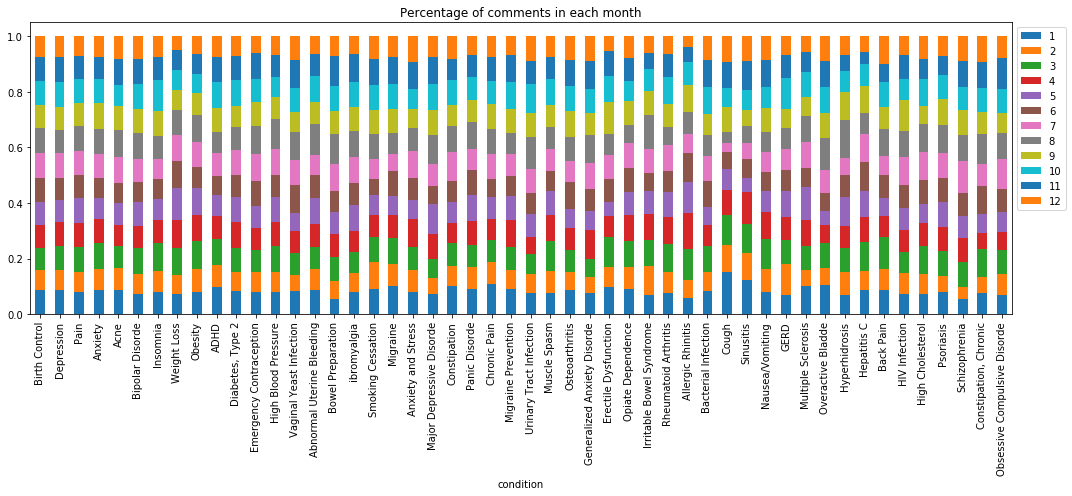

In [248]:
n = 50
top_n_index = df_con_mon_pivot.sum(1).sort_values(ascending=False).iloc[:n].index
tm_con_mon_pivot = df_con_mon_pivot.loc[top_n_index]
tm_con_mon_pivot_per = tm_con_mon_pivot.div(tm_con_mon_pivot.sum(1), axis=0)
tm_con_mon_pivot_per.plot.bar(stacked=True, figsize=(15,7))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Percentage of comments in each month")
plt.tight_layout()
plt.savefig("Plot/Per_comments_month.png")

In [249]:
## avg of comments for each condition in each month
df_con_mon_pivot_sorted = df_con_mon_pivot.loc[df_con_mon_pivot.sum(1).sort_values(ascending=False).index]

df_con_mon_pivot_sorted.sum() / len(df_con_mon_pivot_sorted)
#mon_sick_per = df_con_mon_pivot_sorted.sum()/df_con_mon_pivot_sorted.sum().sum()

month
1     15.356335
2     13.541855
3     15.686652
4     15.442308
5     15.020362
6     14.348416
7     15.580317
8     16.380090
9     15.158371
10    15.804299
11    15.606335
12    13.520362
dtype: float64

In [250]:
sum_months = df_con_mon_pivot_sorted.sum()
all_sum = sum_months.sum()

i = 0 
#df_con_mon_pivot_sorted.iloc[i,:]
expected = df_con_mon_pivot_sorted.sum(0) * (df_con_mon_pivot_sorted.iloc[i,:].sum() / all_sum)
observed = df_con_mon_pivot_sorted.iloc[i,:]
chisquare(observed,f_exp=expected)

Power_divergenceResult(statistic=38.935465364569865, pvalue=5.4327938627447377e-05)

In [251]:
sum_months = df_con_mon_pivot_sorted.sum()
all_sum = sum_months.sum()
chi_result =[]

## only take T > 5 (the cell need 5 records at least)
df_con_mon_pivot_sorted_T5 = df_con_mon_pivot_sorted[(df_con_mon_pivot_sorted > 5).all(1)]
df_con_mon_pivot_sorted_T5.head()

## compare expected and observed using chi-square test
for idx in df_con_mon_pivot_sorted_T5.index:
    ## use 
    expected = df_con_mon_pivot_sorted.sum(0) * (df_con_mon_pivot_sorted.loc[idx,:].sum() / all_sum)
    observed = df_con_mon_pivot_sorted_T5.loc[idx,:]
    
    chi_result.append([idx,chisquare(observed,f_exp=expected)])


In [252]:
df_chi = pd.DataFrame([[a[0],a[1].statistic,a[1].pvalue] for a in chi_result])
df_chi.columns = ['condition','statistic','pvalue']
df_chi['adj_pvalue'] = fdrcorrection_twostage(df_chi['pvalue'])[1]
df_chi.head()

,condition,statistic,pvalue,adj_pvalue
0,Birth Control,38.935465,0.000054,0.000293
1,Depression,19.054616,0.060120,0.083805
2,Pain,9.238257,0.599910,0.425463
3,Anxiety,20.705844,0.036550,0.056828
4,Acne,29.811602,0.001696,0.004424


In [253]:
df_chi_sorted = df_chi[df_chi['adj_pvalue'] < 0.05].sort_values('pvalue')

df_chi_sorted.head(10)

,condition,statistic,pvalue,adj_pvalue
7,Weight Loss,145.652500,1.149992e-25,9.297688e-24
35,Cough,129.962039,1.771886e-22,7.162849e-21
33,Allergic Rhinitis,89.940100,1.712822e-14,4.616054e-13
36,Sinusitis,72.581047,3.936670e-11,7.956994e-10
72,Cough and Nasal Congestion,71.094673,7.562344e-11,1.222831e-09
68,Herpes Simplex,57.745517,2.424612e-08,3.267165e-07
8,Obesity,54.759136,8.577515e-08,9.907030e-07
6,Insomnia,53.858426,1.252668e-07,1.265978e-06
53,Bronchitis,50.674949,4.731868e-07,4.250795e-06
13,Vaginal Yeast Infection,48.344293,1.239355e-06,1.002018e-05


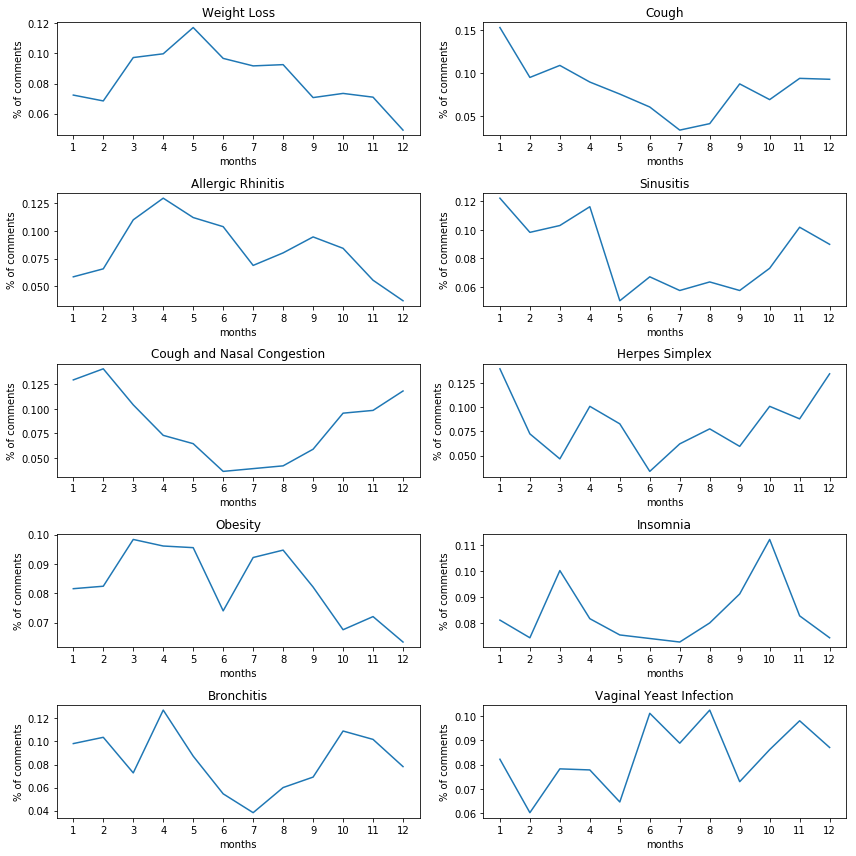

In [254]:

plt.figure(figsize=(12,12))
i =1
for idx in df_chi_sorted['condition'][:10]:
    
    each = df_con_mon_pivot_sorted_T5.loc[idx,:]/df_con_mon_pivot_sorted_T5.loc[idx,:].sum()
    
    plt.subplot(5, 2, i)
    plt.title(idx)
    plt.plot(each)
    plt.xticks(np.arange(1,13,1))
    plt.xlabel('months')
    plt.ylabel('% of comments')
    i = i +1
    
plt.tight_layout()
plt.savefig("Plot/Top_condition_signif_month.png")

# 2. NLP

## 2.1 Sentiment Analysis
### 2.1.1 Vectorizerization of words using tf-idf

In [53]:
## remove special symbol
def rm_sym(df):
    df['review'] = df['review'].str.replace("&#039;",'\'')
    df['review'].head()
    df['rating_cate'] = ''
    df.loc[df['rating'] >= 7,'rating_cate'] = 'high'
    df.loc[df['rating'] <= 4,'rating_cate'] = 'low'
    df.loc[(df['rating'] > 4) & (df['rating'] < 7),'rating_cate'] = 'medium'
    return df
df = rm_sym(df)

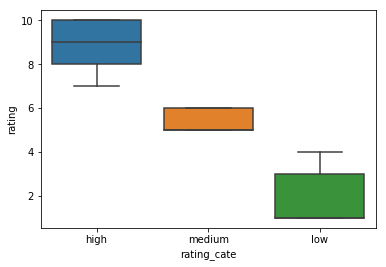

In [54]:
sns.boxplot(x=df['rating_cate'],y=df['rating'])

In [55]:
df_tem = df#.sample(80000)
df_tem.groupby('rating_cate').size() / df_tem.groupby('rating_cate').size().sum()

rating_cate
high      0.662542
low       0.248455
medium    0.089004
dtype: float64

In [58]:
test = pd.read_csv("drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
test = rm_sym(test)

In [59]:
df.shape

(161297, 7)

In [60]:
test.shape

(53766, 7)

In [61]:
import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, roc_auc_score , f1_score
import multiprocessing

## only need to remove punctuation and stemize
stemmer = SnowballStemmer('english')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [62]:
## Generate table of words with their counts
## TfidfVectorizer transform train and test
con_vec = TfidfVectorizer(stop_words='english',tokenizer=tokenize)
X_train = con_vec.fit_transform(df_tem['review'])
y_train = df_tem['rating_cate']
X_test = con_vec.transform(test['review'])
y_test = test['rating_cate']

print(X_train.shape)
print(X_test.shape)

(161297, 65739)
(53766, 65739)


### 2.2.2 Logistic regression
### cross validation

In [65]:
## n_gram -> count word 
lr = LogisticRegression(penalty='l1',multi_class='ovr',solver='saga')
#lr.fit(X,target_3.iloc[:,0])

cv_score = cross_val_score(lr,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [66]:
## TfidfVectorizer

## n = 20000, penalty='l1',multi_class='auto',solver='saga'
## array([0.75971201, 0.75446228, 0.75652565])

## n = 20000, penalty='l1',multi_class='auto',solver='saga'
## array([0.73560288, 0.73826309, 0.739985  ])

## CountVectorizer

## n = 10000, penalty='l1',multi_class='auto',solver='saga'
## array([0.70475705, 0.71251387, 0.70633158])

## n = 20000, penalty='l1',multi_class='auto',solver='saga'
## array([0.71475705, 0.72251387, 0.72633158])

### test set predition

In [109]:
lr = LogisticRegression(penalty='l1', multi_class='ovr',solver='saga',n_jobs=-1)
#y_train2 = pd.get_dummies(y_train)
lr.fit(X_train,y_train)
y_test_predict = lr.predict(X_test)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [110]:
accuracy_score(y_test,y_test_predict)

0.7810698210765168

In [111]:
# all 0.78
# 80000 0.77

In [112]:
lr_conf_mat = confusion_matrix(y_test,y_test_predict)

### importance ranking based on coefficients

In [277]:
from autocorrect import spell

coef_lr = pd.DataFrame(lr.coef_,columns=con_vec.get_feature_names(),index=lr.classes_)

Rating as "high": top 20 of Positive coeffients

Rating as "high": top 20 of Negative coeffients
Rating as "low": top 20 of Positive coeffients

Rating as "low": top 20 of Negative coeffients


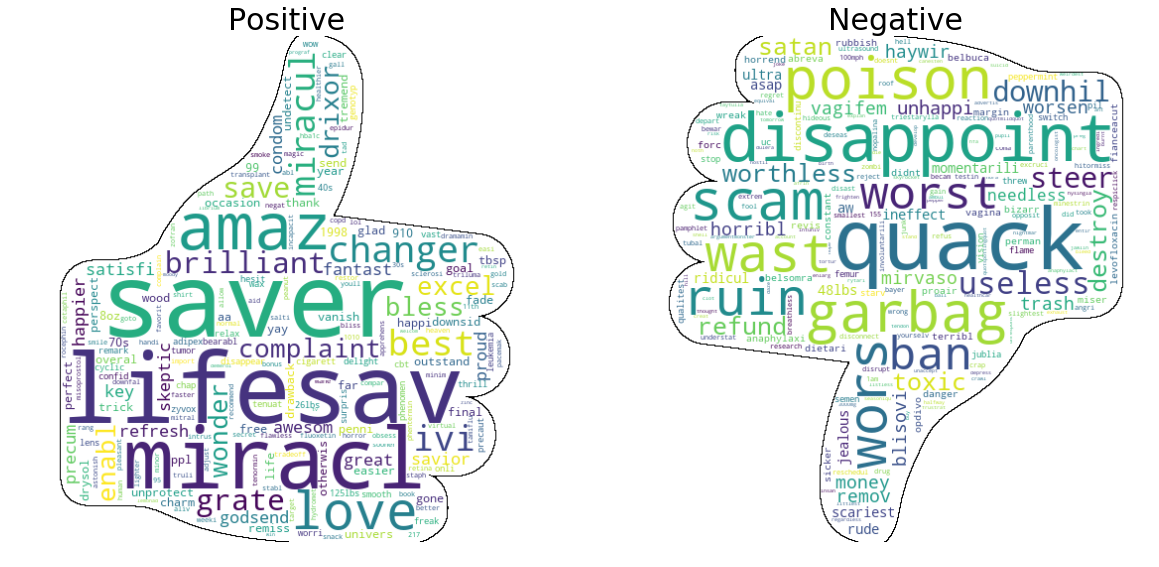

In [308]:
from PIL import Image
import PIL.ImageOps 

thumb_up= np.array(Image.open("Plot/70420.png"))
thumb_up = 255 - thumb_up
thumb_down = np.fliplr(thumb_up)[::-1]

def top_20_pos_neg_wordcloud(category,mask):

    print('Rating as "' + category +'": top 20 of Positive coeffients')
    #print(coef_lr.loc[category].nlargest(20))

    print('\nRating as "' + category +'": top 20 of Negative coeffients')
    #print(coef_lr.loc[category].nsmallest(20))

    wordcloud = WordCloud(contour_width=1,background_color='white',mask=mask)
    wordcloud.generate_from_frequencies(frequencies=coef_lr.loc[category])

    #plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    
plt.figure(figsize=(20,10)) 
plt.subplot(1, 2, 1)
top_20_pos_neg_wordcloud('high',thumb_up)
plt.title("Positive",fontsize=30)

plt.subplot(1, 2, 2)
top_20_pos_neg_wordcloud('low',thumb_down)
plt.title("Negative",fontsize=30)

plt.savefig('Plot/thumb_up_down_wordcloud.png', bbox_inches = 'tight', pad_inches = 0)

In [173]:
#top_20_pos_neg_wordcloud('medium',thumb_down)

In [199]:
# top_20_pos_neg_wordcloud('low',thumb_down)
# plt.title("Negative",fontsize=30)
# plt.savefig('Plot/Neg_senti_lr_wordcloud.png')

### 2.1.2 Random forest classifier

In [72]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
rfc = RandomForestClassifier(n_estimators=400,n_jobs=-1)
rfc_cv_score = cross_val_score(lr,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [74]:
rfc_cv_score

## n_sample = 20000, n_estimators=200
## array([0.76019796, 0.75851207, 0.75513878])

array([0.77601503, 0.77660188, 0.77790384])

In [75]:
rfc = RandomForestClassifier(n_estimators=400,n_jobs=-1,oob_score=True)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [66]:
import pickle
filename = 'finalized_rfc_model.sav'
pickle.dump(rfc, open(filename, 'wb'))

# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, y_test)
# print(result)

In [76]:
y_test_rfc_predict = rfc.predict(X_test)
rfc_conf_mat = confusion_matrix(y_test,y_test_rfc_predict)
accuracy_score(y_test,y_test_rfc_predict)

0.8871591712234498

In [40]:
# all 0.88

### Random forest default feature importances|

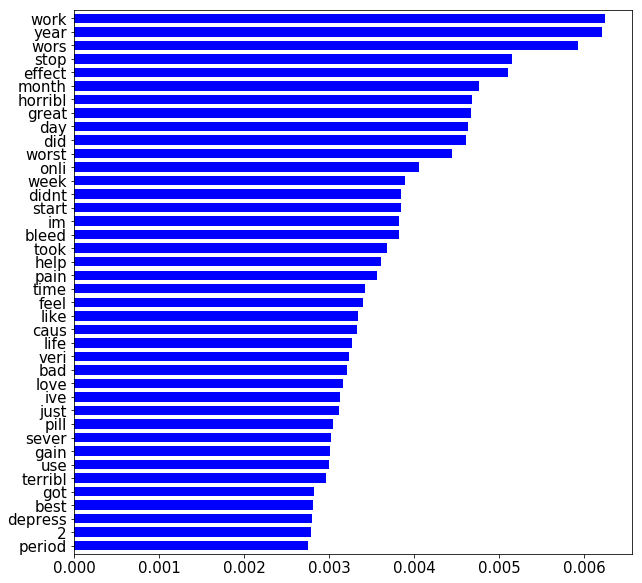

In [24]:
rfc_feature_importances = pd.DataFrame(rfc.feature_importances_,con_vec.get_feature_names())
plt.figure(figsize=(10,10))
rfc_feature_importances[0].nlargest(40)[::-1].plot(kind='barh',color='blue',fontsize=15,width=0.7)
plt.savefig("Plot/rfc_feat_import.png")

### permutation feature importance

In [25]:
X_valid = pd.DataFrame(X_test.toarray(),columns=con_vec.get_feature_names())
y_valid = y_test

In [ ]:

# ## function of permutation feature importance for multicategorical targets
# def permutation_feature_importance(model,X_valid,y_valid,cols=X_valid.columns):
#     ## calulate accuracy for base line (accuracy for origianl X)
#     y_val_predict = model.predict(X_valid)
#     conf_mat_val = confusion_matrix(y_valid,y_val_predict)
#     base_line_three_acc = (conf_mat_val/conf_mat_val.sum(1).reshape(-1,1)).diagonal()
    
#     imp = []

#     for col in cols:
#         save = X_valid[col].copy()
#         ## permutation step
#         X_valid[col] = np.random.permutation(X_valid[col])
#         m = model.predict(X_valid)
#         conf_mat_per = confusion_matrix(y_valid,m)
#         per_three_acc = (conf_mat_per/conf_mat_per.sum(1).reshape(-1,1)).diagonal()
#         X_valid[col] = save
#         acc_diff = base_line_three_acc - per_three_acc
#         print(acc_diff)
#         imp.append(acc_diff)

#     return np.array(imp)
# rfc_feature_importances_top = rfc_feature_importances[0].nlargest(1000)

# perm_fea_imp = permutation_feature_importance(rfc,X_valid,y_valid,cols=rfc_feature_importances_top.index)

## function of permutation feature importance for one targets
def permutation_feature_importance(model,X_valid,y_valid,cols=X_valid.columns):
    base_line = model.score(X_valid,y_valid)
    imp = []

    for col in cols:
        save = X_valid[col].copy()
        ## permutation step
        X_valid[col] = np.random.permutation(X_valid[col])
        m = model.score(X_valid,y_valid)
        X_valid[col] = save
        acc_diff = base_line - m
        print(acc_diff)
        imp.append(acc_diff)

    return np.array(imp)
rfc_feature_importances_top = rfc_feature_importances[0].nlargest(1000)
perm_fea_imp = permutation_feature_importance(rfc,X_valid,y_valid,cols=rfc_feature_importances_top.index)

In [1]:
import multiprocessing

## function of permutation feature importance for multicategorical targets
def permutation_feature_importance(model,X_valid,y_valid,cols=X_valid.columns):
    ## calulate accuracy for base line (accuracy for origianl X)
    y_val_predict = model.predict(X_valid)
    conf_mat_val = confusion_matrix(y_valid,y_val_predict)
    base_line_three_acc = (conf_mat_val/conf_mat_val.sum(1).reshape(-1,1)).diagonal()
    
    imp = []

    for col in cols:
        save = X_valid[col].copy()
        ## permutation step
        X_valid[col] = np.random.permutation(X_valid[col])
        m = model.predict(X_valid)
        conf_mat_per = confusion_matrix(y_valid,m)
        per_three_acc = (conf_mat_per/conf_mat_per.sum(1).reshape(-1,1)).diagonal()
        X_valid[col] = save
        acc_diff = base_line_three_acc - per_three_acc
        print(acc_diff)
        imp.append(acc_diff)

    return np.array(imp)
rfc_feature_importances_top = rfc_feature_importances[0].nlargest(1000)

perm_fea_imp = permutation_feature_importance(rfc,X_valid,y_valid,cols=rfc_feature_importances_top.index)

In [27]:
perm_fea_imp_df = pd.DataFrame(perm_fea_imp)
perm_fea_imp_df.index = rfc_feature_importances_top.index

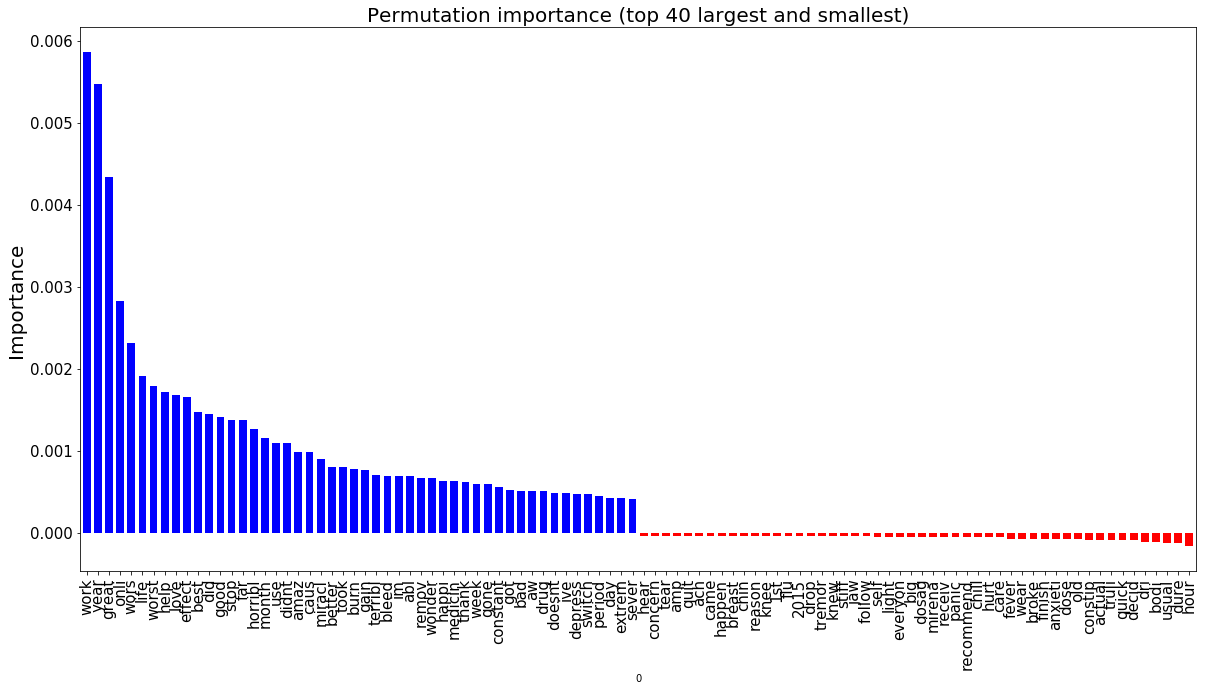

In [48]:
#perm_fea_imp_df = pd.read_csv("Feature_importance/perm_fea_imp.csv",index_col=0,header=None)[1].sort_values()
n_top =50
top_positive_coefficients = list(perm_fea_imp_df.nlargest(n_top).index)
top_negative_coefficients = list(perm_fea_imp_df.nsmallest(n_top)[::-1].index)

plt.figure(figsize=(20,10))
perm_fea_imp_df_top = perm_fea_imp_df.loc[top_positive_coefficients+top_negative_coefficients]
colors = ['red' if c < 0 else 'blue' for c in perm_fea_imp_df_top]
perm_fea_imp_df_top.plot(kind='bar',color=colors,fontsize=15,width=0.7)
plt.title("Permutation importance (top 40 largest and smallest)",fontsize=20)
plt.ylabel("Importance",fontsize=20)
plt.savefig("Plot/perm_fea_imp.png")

In [ ]:
# 0.72

### 2.1.3 Gradient boosting classifier

In [117]:
gbc = GradientBoostingClassifier(n_estimators=300)
gbc_cv_score = cross_val_score(gbc,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
gbc_cv_score

array([0.71025795, 0.69946011, 0.69267707])

In [77]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=300)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [78]:
y_test_gbc_predict = gbc.predict(X_test)
accuracy_score(y_test,y_test_gbc_predict)

0.7468846482907414

In [79]:
gbc_conf_mat = confusion_matrix(y_test,y_test_gbc_predict)
gbc_conf_mat

array([[34171,  1253,    16],
       [ 7549,  5933,    15],
       [ 3899,   877,    53]])

In [ ]:
## cv
## n_sample=20000, n_estimators=600
## ['0.73665267', '0.74066297', '0.73713428']

## n_sample=500, n_estimators=200
## array([0.70845831, 0.69886023, 0.69627851])

## test set
## n_sample=20000, n_estimators=600
## 0.7498419075252017

### 2.1.4 SVM

In [185]:
# df = pd.read_csv('drugsCom_raw/drugsComTrain_raw.tsv',sep='\t',index_col=0)
# df = rm_sym(test)
# df_tem3 = df#.sample(40000)

# test = pd.read_csv("drugsCom_raw/drugsComTest_raw.tsv",sep='\t', index_col=0)
# test = rm_sym(test)

# ## Generate table of words with their counts
# con_vec = TfidfVectorizer(stop_words='english',tokenizer=tokenize)
# X_train = con_vec.fit_transform(df_tem3['review'])
# y_train = df_tem3['rating_cate']

# ## test set

# X_test = con_vec.transform(test['review'])
# y_test = test['rating_cate']

#### rbf

In [176]:
svm_rbf = SVC(kernel='rbf')
gbc_cv_score = cross_val_score(svm_rbf,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
gbc_cv_score

array([0.66061788, 0.66071696, 0.66076519])

In [80]:
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train,y_train)
y_test_pred_svm_rbf = svm_rbf.predict(X_test)

accuracy_score(y_test,y_test_pred_svm_rbf)

0.6591526243350817

In [81]:
svm_rbf_conf_mat = confusion_matrix(y_test,y_test_pred_svm_rbf)
svm_rbf_conf_mat

array([[35440,     0,     0],
       [13497,     0,     0],
       [ 4829,     0,     0]])

#### poly

In [175]:
svm_poly = SVC(kernel='poly')
gbc_cv_score = cross_val_score(svm_poly,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
gbc_cv_score

array([0.66061788, 0.66071696, 0.66076519])

In [94]:
svm_poly = SVC(kernel='poly')
svm_poly.fit(X_train,y_train)
y_test_pred_svm_poly = svm_poly.predict(X_test)

accuracy_score(y_test,y_test_pred_svm_poly)

0.6591526243350817

In [104]:
svm_poly_conf_mat = confusion_matrix(y_test,y_test_pred_svm_poly)
svm_poly_conf_mat

array([[35440,     0,     0],
       [13497,     0,     0],
       [ 4829,     0,     0]])

#### linear

In [171]:
svm_lin = SVC(kernel='linear')
svm_lin_score = cross_val_score(svm_lin,X_train,y_train,scoring='accuracy',cv=3,n_jobs=-1)
svm_lin_score

array([0.75794841, 0.76256187, 0.75213803])

In [82]:
svm_lin = SVC(kernel='linear')
svm_lin.fit(X_train,y_train)
y_test_pred_svm_lin = svm_lin.predict(X_test)

In [83]:
accuracy_score(y_test,y_test_pred_svm_lin)

0.7891976341926125

In [84]:
svm_lin_conf_mat = confusion_matrix(y_test,y_test_pred_svm_lin)
svm_lin_conf_mat

array([[33232,  2206,     2],
       [ 4299,  9198,     0],
       [ 3319,  1508,     2]])

In [ ]:
# 0.78

### 2.1.5 set a baseline which just classifiy everything to the most frequent class

In [85]:
from sklearn.dummy import DummyClassifier
dum = DummyClassifier(strategy='most_frequent')
dum.fit(X_train,y_train)
y_predict_dum = dum.predict(X_test)
accuracy_score(y_test,y_predict_dum)

0.6591526243350817

### 2.1.6 import LSTM result

In [86]:
LSTM_conf_mat = np.array([[32645,  1758,  1037],
       [ 1807, 10959,   731],
       [ 1888,  1708,  1233]])

### 2.1.7 heatmap of confusion matrix of all models

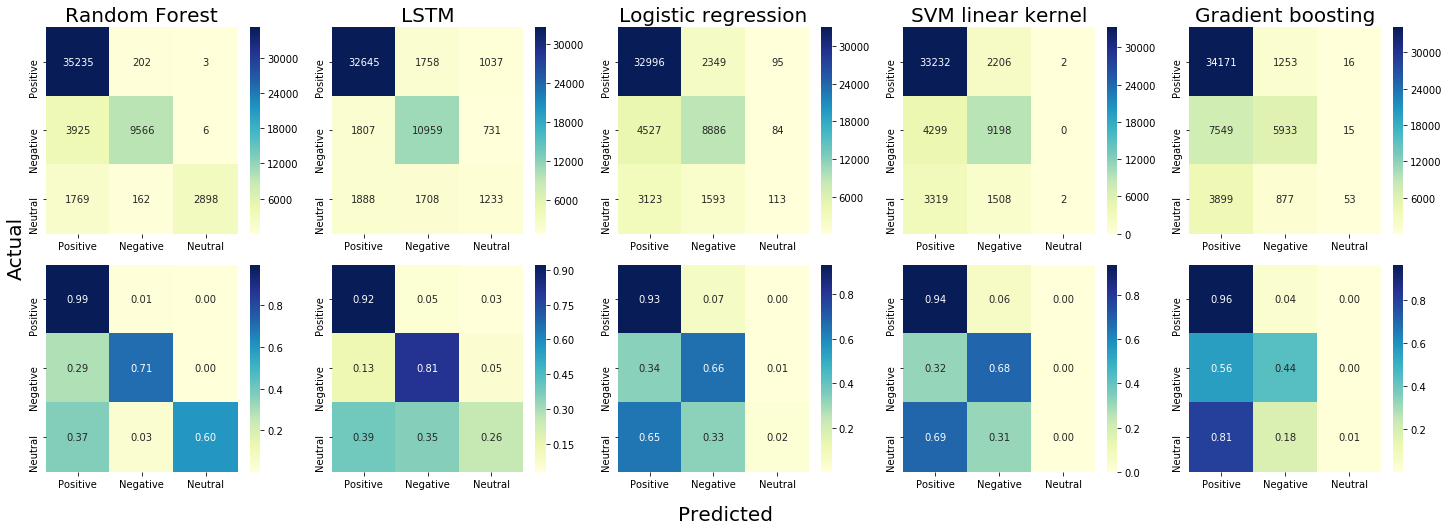

In [88]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_one(rfc_conf_mat,ax1,ax2,cbar=True):
    rfc_conf_mat_per = rfc_conf_mat/(rfc_conf_mat.sum(1).reshape(-1,1))

    rfc_conf_mat = pd.DataFrame(rfc_conf_mat,index=['Positive','Negative','Neutral'],columns=['Positive','Negative','Neutral'])
    rfc_conf_mat_per = pd.DataFrame(rfc_conf_mat_per,index=['Positive','Negative','Neutral'],columns=['Positive','Negative','Neutral'])
    
    sns.heatmap(rfc_conf_mat, annot=True,fmt="d",cmap="YlGnBu",cbar=cbar,ax=ax1)
    sns.heatmap(rfc_conf_mat_per, annot=True,fmt=".2f",cmap="YlGnBu",cbar=cbar,ax=ax2)
    #return counts#,percent]

fig, axes = plt.subplots(2, 5, figsize=(20,7))
plot_one(rfc_conf_mat,axes[0,0],axes[1,0]) #,title='Random Forest')
plot_one(LSTM_conf_mat,axes[0,1],axes[1,1])
plot_one(lr_conf_mat,axes[0,2],axes[1,2])#,title='Linear regression')
plot_one(svm_lin_conf_mat,axes[0,3],axes[1,3])#,title='SVM linear kernel')
plot_one(gbc_conf_mat,axes[0,4],axes[1,4])#,title='Gradient boosting')

axes[0,0].set_title("Random Forest",fontsize=20)
axes[0,1].set_title("LSTM",fontsize=20)
axes[0,2].set_title("Logistic regression",fontsize=20)
axes[0,3].set_title("SVM linear kernel",fontsize=20)
axes[0,4].set_title("Gradient boosting",fontsize=20)
plt.text(-18.5,-0.5,"Actual",fontsize=20,rotation=90)
plt.text(-8,3.7,"Predicted",fontsize=20)
plt.tight_layout()
plt.savefig("Plot/Confusion_matrix_sentiment.png")
# 
# axes[1] = plot_one(lr_conf_mat)[1]